In [1]:
import numpy as np # linear algebra
import pandas as pd
import os
import os
import cv2
import matplotlib.pyplot as plt
import shutil
import random

In [2]:
images = os.listdir('../BT_Detection/axial_t1wce_2_class/images/train')
len(images)

310

In [3]:
labels = os.listdir('../BT_Detection/axial_t1wce_2_class/labels/train')
len(images)

310

In [57]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from skimage.feature import hog
from skimage import color

class BrainTumorNaiveBayesDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform

        # Get all image and label filenames
        self.image_filenames = sorted(os.listdir(images_dir))
        self.label_filenames = sorted(os.listdir(labels_dir))

        # Ensure image and label filenames match
        self.image_filenames = [f for f in self.image_filenames if f.replace('.jpg', '.txt') in self.label_filenames]
        self.label_filenames = [f.replace('.jpg', '.txt') for f in self.image_filenames]

    def extract_hog_features(self, image):
        # Convert to grayscale if not already
        if len(image.shape) == 3:  # RGB image
            image_gray = color.rgb2gray(image)
        else:
            image_gray = image  # Already grayscale

        # Extract HOG features
        features, _ = hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
        return features

    def __getitem__(self, idx):
        # Load image and label
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        label_path = os.path.join(self.labels_dir, self.label_filenames[idx])
        
        image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
        image_width, image_height = image.size  # Get image dimensions
        
        # Read the label (YOLO format)
        with open(label_path, 'r') as file:
            label_data = file.readlines()
        
        boxes = []
        for line in label_data:
            parts = line.strip().split()
            if len(parts) == 5:  # Expected format [class_id, x_center, y_center, width, height]
                class_id, x_center, y_center, width, height = map(float, parts)
                
                # Convert from YOLO format (normalized) to pixel coordinates
                x_min = (x_center - width / 2) 
                y_min = (y_center - height / 2) 
                x_max = (x_center + width / 2) 
                y_max = (y_center + height / 2) 
                
                boxes.append([class_id, x_min, y_min, x_max, y_max])
        
        # Convert bounding boxes to tensor format
        boxes = torch.tensor(boxes, dtype=torch.float32)
        
        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
        
        # Convert image to numpy for feature extraction
        image_np = image.permute(1, 2, 0).numpy()
        feature = self.extract_hog_features(image_np)
        
        # Return image, bounding boxes, and HOG features
        return image, boxes, torch.tensor(feature, dtype=torch.float32)

    def __len__(self):
        return len(self.image_filenames)

In [100]:
from sklearn.ensemble import RandomForestRegressor
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
# Define transforms to convert images to tensors
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 256x256 (you can change the size)
    transforms.ToTensor(),  # Convert image to tensor
])

dataset = BrainTumorNaiveBayesDataset(images_dir='../BT_Detection/axial_t1wce_2_class/images/train', labels_dir='../BT_Detection/axial_t1wce_2_class/labels/train', transform=transform)
loader = DataLoader(dataset, batch_size=len(dataset))

# Prepare features and labels
features = []
labels = []

for i in range(len(dataset)):
    image, bbox, feature = dataset[i]  # Get image, bbox, and HOG feature

    if(bbox.flatten().shape[0] != 5):
        continue
    features.append(feature)  # Convert to numpy
    labels.append(bbox.flatten())

features = np.array(features)  # Convert list to numpy array
labels = np.array(labels)  # Convert labels to numpy
# Split the data into train and test sets
if len(features) > 1:
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
else:
    X_train, y_train = features, labels  # No split needed


# Train Random Forest model
model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Evaluate accuracy (for regression tasks, use error metrics)
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 0.17


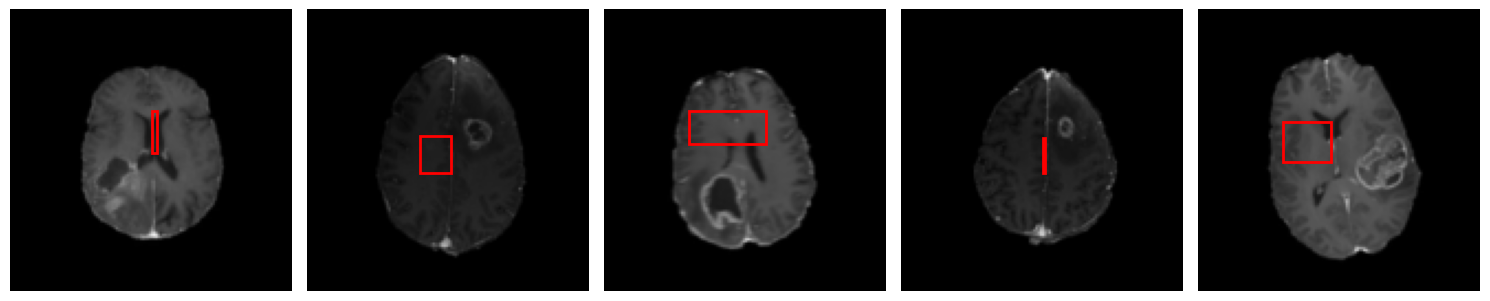

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from torchvision import transforms

# Dataset initialization for test data
dataset_test = BrainTumorNaiveBayesDataset(
    images_dir='../BT_Detection/axial_t1wce_2_class/images/test', 
    labels_dir='../BT_Detection/axial_t1wce_2_class/labels/test', 
    transform=transform
)

# DataLoader for test data
loader_test = DataLoader(dataset_test, batch_size=1)

# Randomly select 5 indices from the test dataset
num_samples_to_plot = 5
random_indices = random.sample(range(len(loader_test)), num_samples_to_plot)

# Plot the randomly selected test samples
fig, axes = plt.subplots(1, num_samples_to_plot, figsize=(15, 5))

# Ensure axes is iterable if there's only one subplot
if num_samples_to_plot == 1:
    axes = [axes]

# Loop through the random indices and plot
for ax, idx in zip(axes, random_indices):
    # Get image, bbox, and feature from the selected random sample
    img, bbox, feature = dataset_test[idx]
    
    # Convert the image to numpy and squeeze if necessary
    img = img.squeeze(0).permute(1, 2, 0).numpy()
    
    # Get the predicted bounding box for the image (use feature for prediction)
    pred_bbox = model.predict([feature.numpy().flatten()])[0]  # Flatten feature for prediction

    # Get predicted bounding box coordinates
    x_min, y_min, x_max, y_max, _ = pred_bbox

    # Rescale the bounding box coordinates to match the original image size
    x_min = int(x_min * img.shape[1])
    y_min = int(y_min * img.shape[0])
    x_max = int(x_max * img.shape[1])
    y_max = int(y_max * img.shape[0])

    # Plot the image
    ax.imshow(img)

    # Plot the bounding box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.axis('off')

plt.tight_layout()
plt.show()